Loading Ethereum Data...
Data Shape: (9841, 39)
Fraud Distribution:
FLAG
0    7662
1    2179
Name: count, dtype: int64
Training XGBoost (Weight: 3.49)...

--- Ethereum Fraud Detection Results ---
              precision    recall  f1-score   support

       Licit       0.98      0.97      0.97      1542
       Fraud       0.90      0.92      0.91       427

    accuracy                           0.96      1969
   macro avg       0.94      0.95      0.94      1969
weighted avg       0.96      0.96      0.96      1969

Training Accuracy: 0.9981
Test Accuracy:     0.9594


<Figure size 1000x600 with 0 Axes>

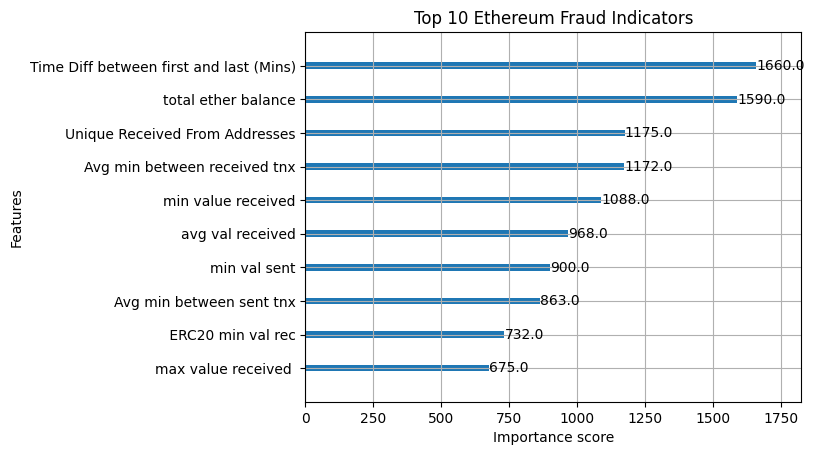

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
# 1. LOAD DATA
DATA_PATH = '../data/transaction_dataset.csv'
print("Loading Ethereum Data...")
df = pd.read_csv(DATA_PATH)

# 2. CLEANING (Updated to fix the 'Cofoundit' error)
# Drop ID columns that don't help prediction
df = df.drop(columns=['Index', 'Address'])

# --- THE FIX: Select only NUMBER columns ---
# This removes any hidden text columns (like Token Names) that break the math
df = df.select_dtypes(include=[np.number])

# Drop columns with 0 variance (columns where every value is the same)
df = df.loc[:, df.var() != 0]

# Fill missing values (NaN) with 0
df = df.fillna(0)
df = df.drop(columns=['Unnamed: 0'])
print(f"Data Shape: {df.shape}")
print(f"Fraud Distribution:\n{df['FLAG'].value_counts()}")

# 3. PREPARE TRAINING
X = df.drop(columns=['FLAG'])
y = df['FLAG']

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. TRAIN XGBOOST
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_weight = neg / pos

print(f"Training XGBoost (Weight: {scale_weight:.2f})...")

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    scale_pos_weight=scale_weight,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# 5. EVALUATE
print("\n--- Ethereum Fraud Detection Results ---")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Licit', 'Fraud']))
# Check Training Accuracy vs Test Accuracy
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(f"Training Accuracy: {accuracy_score(y_train, train_pred):.4f}")
print(f"Test Accuracy:     {accuracy_score(y_test, test_pred):.4f}")
# 6. FEATURE IMPORTANCE
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10, importance_type='weight', title='Top 10 Ethereum Fraud Indicators')
plt.show()

In [9]:
from sklearn.model_selection import cross_val_score

# Define the model (same params as before)
# We re-initialize it to ensure it's fresh
xgb_cv = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    scale_pos_weight=scale_weight,
    random_state=42,
    n_jobs=-1,
    verbosity=0  # Silent mode
)

print("Running 5-Fold Cross-Validation...")
# This will take a moment as it trains 5 times
cv_scores = cross_val_score(xgb_cv, X, y, cv=5, scoring='accuracy')

print(f"\nCV Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Running 5-Fold Cross-Validation...

CV Scores: [0.95987811 0.97002033 0.9679878  0.96697154 0.96493902]
Mean Accuracy: 0.9660
Standard Deviation: 0.0035


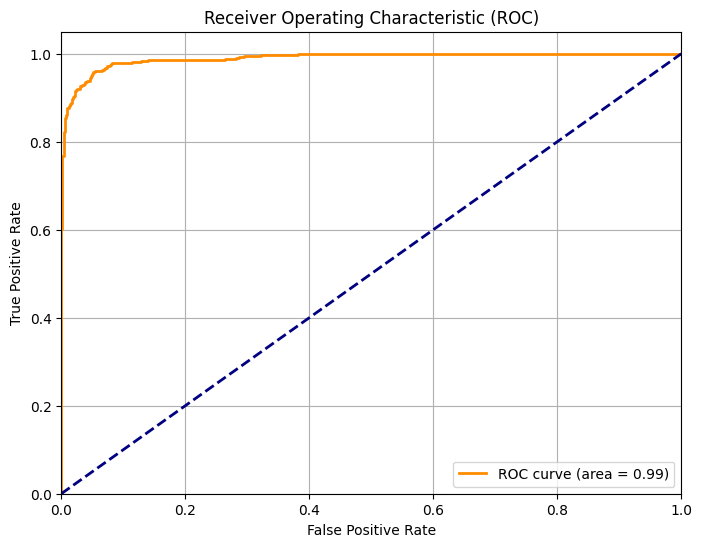

In [10]:
from sklearn.metrics import roc_curve, auc

# Get probabilities for the "1" class (Fraud)
y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [12]:
!pip install shap

INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ------------------- -------------------- 262.1/548.0 kB ? eta -:--:--
   ---------------------------------------- 548.0/548.0 kB 913.2 kB/s  0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   --- 

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


<Figure size 800x800 with 0 Axes>

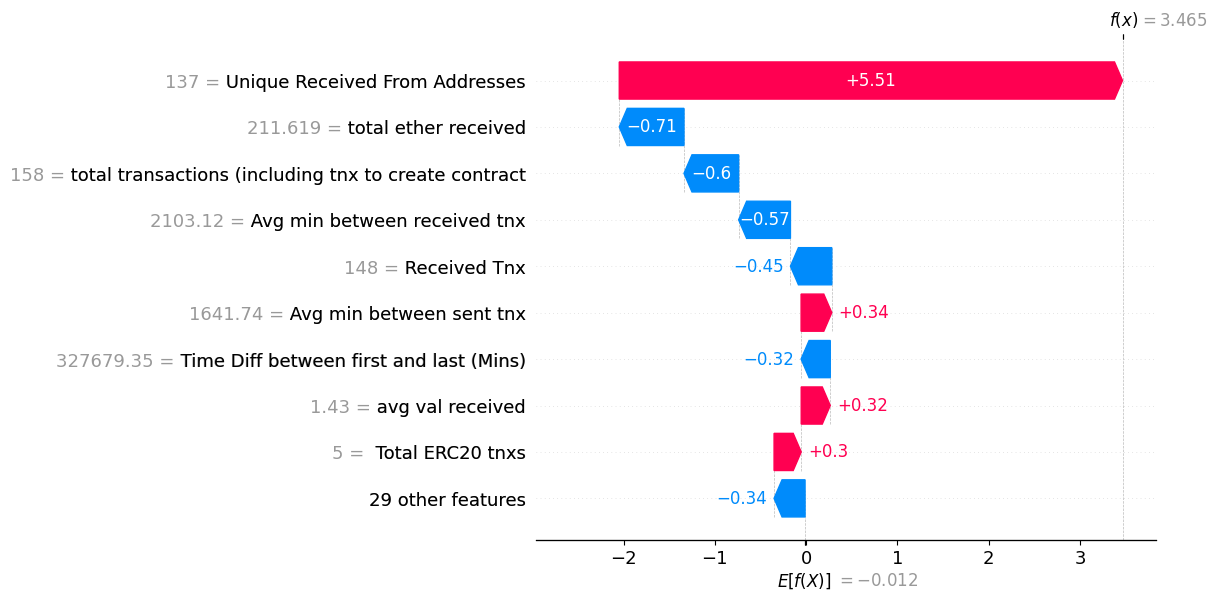

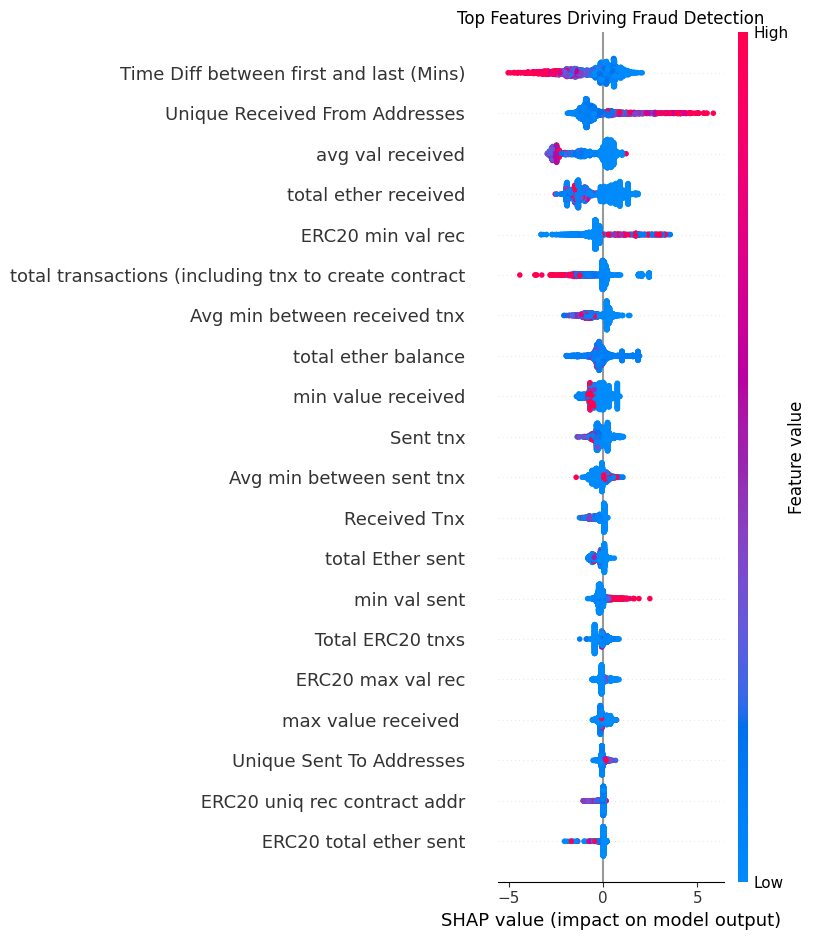

In [17]:
import shap
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# 1. Create a SHAP Explanation object manually
# This bundles the data, values, and base value together correctly
explanation = shap.Explanation(
    values=shap_values[0],               # SHAP values for the first transaction
    base_values=explainer.expected_value, # The baseline risk score (scalar)
    data=X_test.iloc[0],                 # The actual feature values
    feature_names=X_test.columns         # The feature names
)

# 2. Plot
plt.figure(figsize=(10, 6))
shap.waterfall_plot(explanation)
plt.show()
# Global Interpretability (The "Bird's Eye View")
plt.figure(figsize=(10, 8))
plt.title("Top Features Driving Fraud Detection")
shap.summary_plot(shap_values, X_test, show=False)
plt.show()

In [18]:
import joblib

# 1. Save the trained model
joblib.dump(model, 'fraud_model.pkl')

# 2. Save the column names 
# (We need this to ensure the website inputs match the model exactly)
joblib.dump(X_train.columns, 'model_features.pkl')

print("✅ Model saved! You are ready to build the app.")

✅ Model saved! You are ready to build the app.
